# Tugas 4 Deep Learning - Klasifikasi Batik menggunakan CNN

**Kelompok 3**
- Muhammad Alvinza (2304879)
- Muhammad Ichsan Khairullah (2306924)
- Abdurrahman Rauf Budiman (2301102)
- Rasendriya Andhika (2305309)

## 1. Pendahuluan

Pada tugas 4 kali ini, kita diberikan tantangan untuk membangun model klasifikasi citra digital menggunakan Convolutional Neural Network (CNN). Dan kami berniat untuk fokus pada pengenalan dua motif nusantara, yaitu Batik Parang dan Batik Mega Mendung. Proyek ini dirancang tidak hanya untuk sekadar melakukan klasifikasi, tetapi juga sebagai studi komparatif untuk membandingkan performa antara model Convolutional Neural Network (CNN) yang dibangun dari awal (from scratch) dengan teknik Transfer Learning menggunakan arsitektur MobileNetV2. Pengerjaan tugas ini bertujuan untuk memahami bagaimana perbedaan arsitektur jaringan saraf dapat mempengaruhi akurasi dalam mengenali pola visual yang kompleks dalam konteks pembelajaran mesin mendalam (Deep Learning).

Dataset yang digunakan mencakup citra digital dari kedua motif tersebut, di mana Batik Parang memiliki karakteristik pola diagonal berulang yang menyerupai huruf 'S' jalin-menjalin, sedangkan Batik Mega Mendung identik dengan motif awan bergaris lengkung dan gradasi warna khas Cirebon. Untuk memperdalam analisis, kami menerapkan strategi preprocessing data yang terbagi menjadi dua pendekatan: pendekatan Raw yang mempertahankan citra RGB asli, dan pendekatan Experimental (Exp) yang mengubah citra menjadi grayscale serta menerapkan teknik augmentasi data. Pendekatan ini dilakukan untuk menguji apakah penyederhanaan kanal warna dan penambahan variasi data dapat membantu model fokus pada tekstur dan pola geometris batik.

Dalam proses pelatihan, kami menerapkan enam skenario eksperimen yang mencakup kombinasi arsitektur model dan variasi bentuk data. Tiga skenario pertama menggunakan model Scratch, masing masing dengan data Raw, data Gray, serta data Gray dengan augmentasi untuk melihat pengaruh warna, tekstur, dan ketahanan terhadap perubahan spasial. Tiga skenario berikutnya menggunakan arsitektur MobileNetV2 yang dilatih pada data Raw, data Gray, dan data Gray dengan augmentasi, dengan tujuan menilai efektivitas transfer learning pada kondisi data yang berbeda. Seluruh skenario dilatih menggunakan pemantauan metrik evaluasi dan penerapan Early Stopping agar proses berlangsung efisien tanpa meningkatkan risiko overfitting. Pendekatan ini dilakukan untuk membangun sistem klasifikasi batik yang lebih andal sekaligus memahami sejauh mana praproses data dan pemilihan arsitektur memengaruhi performa model CNN dalam mengenali motif batik.

## 2. Import Library & Konfigurasi

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix
import seaborn as sns

# Deteksi environment: Google Colab atau Local
try:
    from google.colab import drive
    IN_COLAB = True
    print("Running in Google Colab")
    drive.mount('/content/drive')
except:
    IN_COLAB = False
    print("Running in Local Environment")

# Konfigurasi
BATCH_SIZE = 128
IMG_HEIGHT = 224
IMG_WIDTH = 224
SEED = 123
EPOCHS = 30  # Dinaikkan dari 15

# Path otomatis berdasarkan environment
if IN_COLAB:
    DATA_DIR = '/content/drive/MyDrive/Kuliah/DeepL/USED_DATASETS'
    MODEL_SAVE_PATH = '/content/drive/MyDrive/Kuliah/DeepL/Models/'
else:
    DATA_DIR = 'Dataset/USED_DATASETS'
    MODEL_SAVE_PATH = 'Models/'

os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

print("TensorFlow Version:", tf.__version__)
print(f"Dataset Path: {DATA_DIR}")
print(f"Model Save Path: {MODEL_SAVE_PATH}")

Running in Local Environment
TensorFlow Version: 2.20.0
Dataset Path: Dataset/USED_DATASETS
Model Save Path: Models/


Pada tahap ini, kita memanggil seluruh pustaka (library) esensial yang dibutuhkan, mulai dari TensorFlow dan Keras untuk membangun arsitektur Deep Learning, hingga alat bantu visualisasi dan manipulasi data seperti Matplotlib, Seaborn, dan NumPy. 

Notebook ini menggunakan **dual-mode configuration** yang dapat berjalan di dua environment:
- **Google Colab**: Otomatis mount Google Drive dan gunakan path cloud storage
- **Local (Windows/Mac/Linux)**: Gunakan path dataset lokal

Yang perlu diperhatikan pada bagian ini adalah penyesuaian Hyperparameter yang kami lakukan:

- Batch Size jumlahnya adalah 128 untuk mempercepat proses pelatihan.
- Epochs jumlahnya adalah 30 yang dapat memberikan model kesempatan belajar yang lebih panjang untuk menangkap pola batik yang rumit.
- Dimensi Citra ditetapkan standar pada 224x224 piksel

## 3. Load Dataset (Raw)

Selanjutnya, kita memuat seluruh data citra langsung dari direktori penyimpanan. Pada tahap ini, data diperlakukan sebagai Raw Dataset karena kita memuatnya dalam format RGB asli tanpa modifikasi warna.

In [4]:
# 1. Load Full Dataset
full_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    seed=SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True
)

class_names = full_dataset.class_names
print("\nKelas:", class_names)

# 2. Split Dataset (70% Train, 15% Val, 15% Test)
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.15, test_split=0.15, shuffle=True, shuffle_size=1000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=SEED)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

raw_train_ds, raw_val_ds, raw_test_ds = get_dataset_partitions_tf(full_dataset)

print(f"Batch counts - Train: {len(raw_train_ds)}, Val: {len(raw_val_ds)}, Test: {len(raw_test_ds)}")

# Menghitung dan menampilkan jumlah gambar
train_count = len(raw_train_ds) * BATCH_SIZE
val_count = len(raw_val_ds) * BATCH_SIZE
test_count = len(raw_test_ds) * BATCH_SIZE
# Perkiraan total, karena batch terakhir mungkin tidak penuh
total_image_count = len(full_dataset.file_paths)

print(f"Image counts - Train: ~{train_count}, Val: ~{val_count}, Test: ~{test_count} (Total: {total_image_count})")

Found 1000 files belonging to 2 classes.

Kelas: ['batik_megamendung', 'batik_parang']
Batch counts - Train: 5, Val: 1, Test: 2
Image counts - Train: ~640, Val: ~128, Test: ~256 (Total: 1000)

Kelas: ['batik_megamendung', 'batik_parang']
Batch counts - Train: 5, Val: 1, Test: 2
Image counts - Train: ~640, Val: ~128, Test: ~256 (Total: 1000)


Setelah data dimuat, kita membaginya (split) menjadi tiga partisi utama agar proses evaluasi berjalan objektif:
- 70% Training Data: Digunakan untuk melatih model mempelajari pola batik.
- 15% Validation Data: Digunakan untuk memantau performa model saat proses pelatihan berlangsung.
- 15% Test Data: Disimpan khusus untuk pengujian akhir guna melihat performa model pada data yang benar-benar baru.

Berdasarkan output kode di atas, terlihat bahwa sistem berhasil memuat total 1.000 file gambar yang terorganisir ke dalam dua kelas target kita, yaitu `batik_megamendung` dan `batik_parang`. Setelah dilakukan pembagian dataset, datanya terdistribusi ke dalam sejumlah batch (kelompok data) untuk efisiensi memori. Kita mendapatkan 11 batch yang dialokasikan khusus untuk proses pelatihan (training), 2 batch untuk validasi selama pelatihan, dan 3 batch sisanya disimpan sebagai data uji (testing). Dengan distribusi ini, komposisi data kita sudah rapi dan siap untuk masuk ke tahap pelatihan model.

## 4. Persiapan Dataset Experimental (Exp)

Pada tahap ini, kami membuat variasi dataset baru yang disebut Dataset Experimental (Exp). Tujuannya adalah untuk menguji apakah model bisa belajar lebih baik jika kita "memaksanya" fokus pada tekstur dan pola, bukan sekadar warna.

In [5]:
# Definisi Augmentasi
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="data_augmentation")

# Fungsi: RGB -> Grayscale -> 3 Channel (agar shape tetap kompatibel)
def to_grayscale_3ch(image, label):
    img = tf.image.rgb_to_grayscale(image)
    img = tf.image.grayscale_to_rgb(img)
    return img, label

# Fungsi wrapper augmentasi
def augment_data(image, label):
    return data_augmentation(image), label

# --- Pipeline Dataset Experimental ---

# Exp Train: Grayscale + Augmentasi
exp_gray_train_ds = raw_train_ds.map(to_grayscale_3ch, num_parallel_calls=tf.data.AUTOTUNE)
exp_gray_aug_train_ds = exp_gray_train_ds.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)

# Exp Val & Test: Hanya Grayscale
exp_val_ds = raw_val_ds.map(to_grayscale_3ch, num_parallel_calls=tf.data.AUTOTUNE)
exp_test_ds = raw_test_ds.map(to_grayscale_3ch, num_parallel_calls=tf.data.AUTOTUNE)

# Optimasi Performa (Prefetching) untuk SEMUA dataset
#def configure_performance(ds):
#    return ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
#
#raw_train_ds = configure_performance(raw_train_ds)
#raw_val_ds = configure_performance(raw_val_ds)
#raw_test_ds = configure_performance(raw_test_ds)
#
#exp_train_ds = configure_performance(exp_train_ds)
#exp_val_ds = configure_performance(exp_val_ds)
#exp_test_ds = configure_performance(exp_test_ds)

Prosesnya melibatkan dua langkah utama:

- **Konversi Grayscale & Re-channeling:**  
  Seluruh citra (Train, Val, Test) diubah menjadi hitam putih (grayscale) untuk menonjolkan struktur motif batik. Tapi, triknya di sini adalah kami mengonversinya kembali ke format 3 channel (RGB) secara teknis, meskipun visualnya tetap hitam putih agar dimensi datanya tetap kompatibel dengan input layer arsitektur MobileNetV2.

- **Augmentasi Data:**  
  Khusus untuk data latih (training set), kami menerapkan Augmentasi Data. Citra dimanipulasi secara acak melalui teknik RandomFlip, RandomRotation, RandomZoom, dan RandomContrast. Ini dilakukan agar model tidak sekadar menghafal data, melainkan belajar mengenali motif dari berbagai posisi dan kondisi visual yang berbeda.

## 5. Visualisasi Perbandingan Data
Di tahap ini, kami menampilkan sampel acak dari dataset Raw dan Experimental secara berdampingan. Langkah ini memastikan teknik preprocessing kita sudah tereksekusi dengan benar sebelum data masuk ke dalam model.

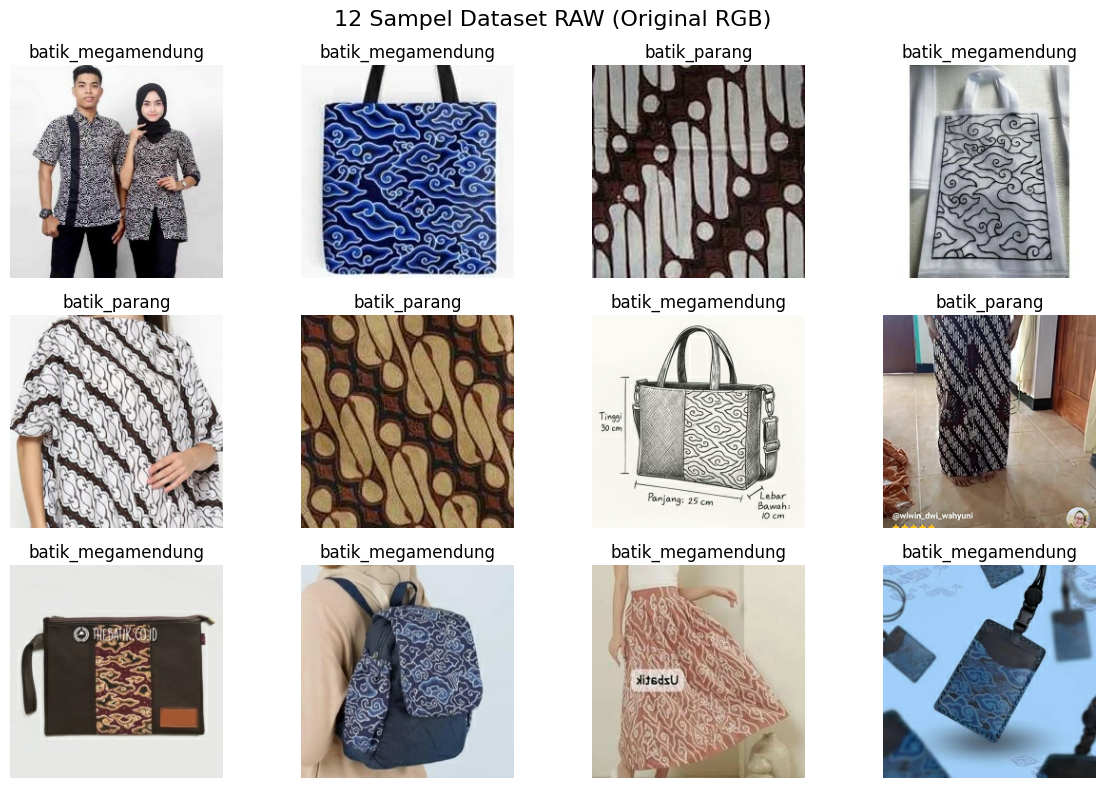

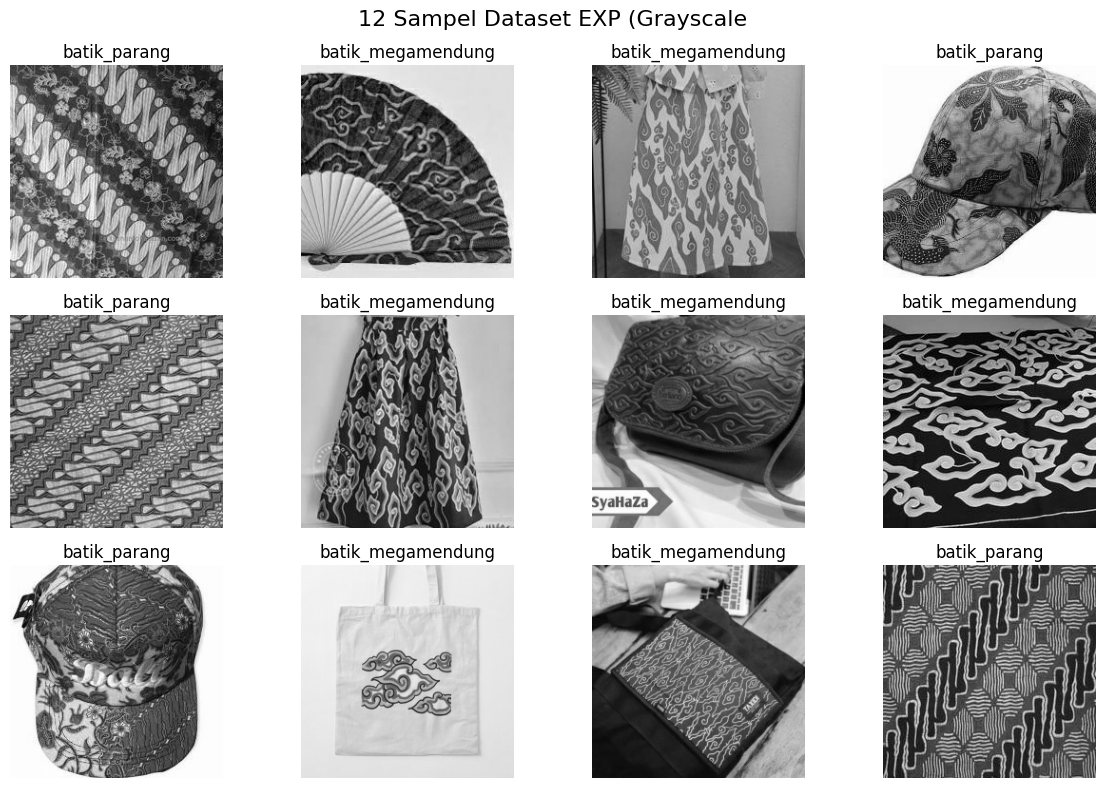

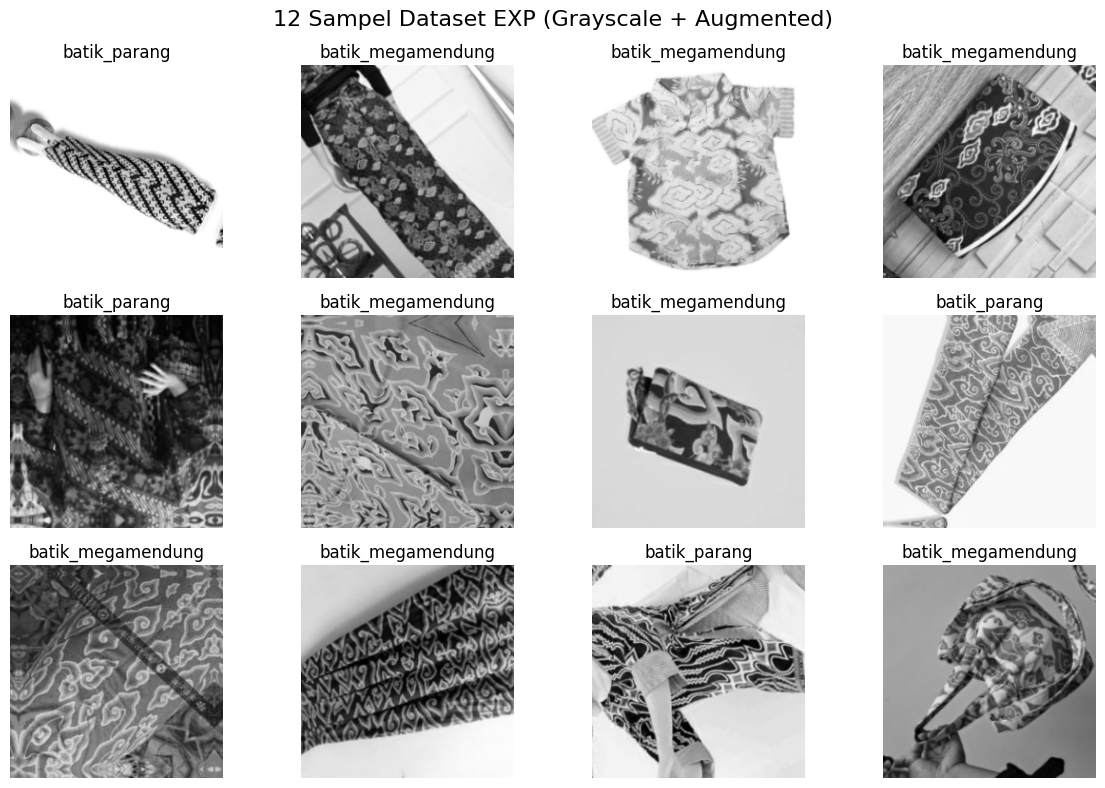

In [6]:
def show_samples(dataset, title):
    plt.figure(figsize=(12, 8))
    plt.suptitle(title, fontsize=16)
    for images, labels in dataset.take(1):
        for i in range(12):
            ax = plt.subplot(3, 4, i + 1)
            # Menampilkan gambar (konversi ke uint8 untuk display yang benar)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
    plt.tight_layout()
    plt.show()

# Tampilkan Sampel Raw
show_samples(raw_train_ds, "12 Sampel Dataset RAW (Original RGB)")

# Tampilkan Sampel Exp
show_samples(exp_gray_train_ds, "12 Sampel Dataset EXP (Grayscale")
show_samples(exp_gray_aug_train_ds, "12 Sampel Dataset EXP (Grayscale + Augmented)")

Dari visualisasi di atas, kita bisa melihat perbedaan mendasar strategi pelatihan yang akan kita uji:

- **Dataset Raw**: Citra masih menampilkan warna asli kain batik yang kaya. Pada skenario ini, model memiliki akses penuh ke fitur warna dan mungkin akan menggunakannya sebagai indikator utama klasifikasi.

- **Dataset Experimental (Grayscale + Augmentation)**: Nah, di sini perbedaannya sangat kontras. Informasi warna telah dihilangkan total (grayscale), sehingga model "dipaksa" untuk belajar mengenali motif murni dari tekstur, garis, dan pola geometrisnya saja. Selain itu, efek augmentasi juga terlihat jelas; beberapa gambar tampak mengalami rotasi dan zoom, yang diharapkan dapat melatih model menjadi lebih tangguh (robust).

Secara keseluruhan, visualisasi ini mengonfirmasi bahwa tahapan preprocessing kita telah berjalan sesuai rencana dan siap untuk diuji. Perbedaan kontras antara dataset Raw yang masih mengandalkan fitur warna dan dataset Experimental (Grayscale + Augmentation) yang menonjolkan tekstur serta variasi posisi ini menjadi landasan eksperimen kita selanjutnya.

## 6. Definisi Model
Pada tahap ini, kita merancang dua skenario arsitektur "otak" yang akan diadu kemampuannya.

In [5]:
# A. Fungsi Membuat Model Scratch (CNN Sederhana)
def create_scratch_model():
    model = models.Sequential([
        layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5), # Dropout untuk mengurangi overfitting
        layers.Dense(2, activation='softmax') # 2 Kelas
    ])

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model

# B. Fungsi Membuat Model MobileNetV2 (Transfer Learning)
def create_mobilenet_model():
    base_model = MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                             include_top=False,
                             weights='imagenet')
    base_model.trainable = False # Freeze base model

    model = models.Sequential([
        layers.Rescaling(1./127.5, offset=-1, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)), # Preprocess khusus MobileNet
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.2),
        layers.Dense(2, activation='softmax')
    ])

    model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), # Learning rate lebih kecil untuk fine-tuning
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model

Ada dua model yang akan diproses dan dianalisis, diantaranya:

- **Model A: CNN from Scratch (Sederhana):**  
  Ini adalah model yang kita bangun murni dari nol. Arsitekturnya klasik, terdiri dari tumpukan layer konvolusi dan pooling untuk mengekstraksi fitur secara bertahap. Kami menyisipkan layer Dropout (0.5) sebelum layer output, sebuah teknik penting untuk "mematikan" sebagian neuron secara acak agar model tidak overfitting (terlalu menghafal data latih).

- **Model B: MobileNetV2 (Transfer Learning):**  
  Untuk model kedua, kita meminjam arsitektur MobileNetV2 yang sudah terlatih pada dataset raksasa ImageNet. Strateginya adalah membekukan (freeze) base model agar bobot lamanya tidak rusak, lalu kita hanya menambahkan dan melatih bagian "kepala" (layer akhir) saja. Perhatikan bahwa kita menggunakan learning rate yang sangat kecil (0.0001) di sini agar penyesuaian model terhadap motif batik berjalan halus dan stabil.

## 7. Eksekusi Training (6 Skenario)
Kita akan melatih 6 kombinasi Model x Dataset.

In [6]:
# Callback Early Stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,             # Stop jika tidak membaik selama 10 epoch
    restore_best_weights=True, # Kembalikan bobot terbaik
    verbose=1
)

# --- 1. Train Scratch pada RAW ---
print("\n=== 1. Training Scratch Model (RAW Data) ===")
model_scratch_raw = create_scratch_model()
hist_scratch_raw = model_scratch_raw.fit(
    raw_train_ds, validation_data=raw_val_ds,
    epochs=EPOCHS,
    callbacks=[early_stop]
)
model_scratch_raw.save(os.path.join(MODEL_SAVE_PATH, 'model_scratch_raw.keras'))

# --- 2. Train Scratch pada EXP ---
print("\n=== 2. Training Scratch Model (gray Data) ===")
model_scratch_exp_gray = create_scratch_model()
hist_scratch_exp_gray = model_scratch_exp_gray.fit(
    exp_gray_train_ds, validation_data=exp_val_ds,
    epochs=EPOCHS,
    callbacks=[early_stop]
)
model_scratch_exp_gray.save(os.path.join(MODEL_SAVE_PATH, 'model_scratch_exp_gray.keras'))

# --- 3. Train Scratch pada EXP ---
print("\n=== 3. Training Scratch Model (gray + aug Data) ===")
model_scratch_exp_gray_aug = create_scratch_model()
hist_scratch_exp_gray_aug = model_scratch_exp_gray_aug.fit(
    exp_gray_aug_train_ds, validation_data=exp_val_ds,
    epochs=EPOCHS,
    callbacks=[early_stop]
)
model_scratch_exp_gray_aug.save(os.path.join(MODEL_SAVE_PATH, 'model_scratch_exp_gray_aug.keras'))

# --- 4. Train MobileNet pada RAW ---
print("\n=== 4. Training MobileNetV2 (RAW Data) ===")
model_mobilenet_raw = create_mobilenet_model()
hist_mobilenet_raw = model_mobilenet_raw.fit(
    raw_train_ds, validation_data=raw_val_ds,
    epochs=EPOCHS,
    callbacks=[early_stop]
)
model_mobilenet_raw.save(os.path.join(MODEL_SAVE_PATH, 'model_mobilenet_raw.keras'))

# --- 5. Train MobileNet pada EXP ---
print("\n=== 5. Training MobileNetV2 (gray Data) ===")
model_mobilenet_exp_gray = create_mobilenet_model()
hist_mobilenet_exp_gray = model_mobilenet_exp_gray.fit(
    exp_gray_train_ds, validation_data=exp_val_ds,
    epochs=EPOCHS,
    callbacks=[early_stop]
)
model_mobilenet_exp_gray.save(os.path.join(MODEL_SAVE_PATH, 'model_mobilenet_exp_gray.keras'))

# --- 6. Train MobileNet pada EXP ---
print("\n=== 6. Training MobileNetV2 (gray + aug Data) ===")
model_mobilenet_exp_gray_aug = create_mobilenet_model()
hist_mobilenet_exp_gray_aug = model_mobilenet_exp_gray_aug.fit(
    exp_gray_aug_train_ds, validation_data=exp_val_ds,
    epochs=EPOCHS,
    callbacks=[early_stop]
)
model_mobilenet_exp_gray_aug.save(os.path.join(MODEL_SAVE_PATH, 'model_mobilenet_exp_gray_aug.keras'))
print("\nSemua model telah dilatih dan disimpan di:", MODEL_SAVE_PATH)


=== 1. Training Scratch Model (RAW Data) ===
Epoch 1/30


C:\Users\RakaP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.5049 - loss: 3.3438 - val_accuracy: 0.5000 - val_loss: 0.7757
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.5049 - loss: 3.3438 - val_accuracy: 0.5000 - val_loss: 0.7757
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.5649 - loss: 0.7071 - val_accuracy: 0.7109 - val_loss: 0.6207
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.5649 - loss: 0.7071 - val_accuracy: 0.7109 - val_loss: 0.6207
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 26s 5s/step - accuracy: 0.6953 - loss: 0.6026 - val_accuracy: 0.6797 - val_loss: 0.5880
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 26s 5s/step - accuracy: 0.6953 - loss: 0.6026 - val_accuracy: 0.6797 - val_loss: 0.5880
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 38s 8s/step - accuracy: 0.7094 - loss: 0.5875 - val_accuracy: 0.7578 - val_loss: 0.5371
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 38s 8s/step - accuracy: 0.7094 - loss: 0.5875 - val_accuracy: 0.7578 - val_loss: 0.5371
Epoch 5/30
5/5 ━━━━

Di tahap ini, kami melatih enam variasi model secara berurutan. Diantaranya:
| No | Skenario Pelatihan | Deskripsi Singkat |
|----|--------------------|-------------------|
| 1 | Scratch Model (Raw Data) | Model Scratch dengan data RGB |
| 2 | Scratch Model (Gray Data) | Model Scratch dengan data grayscale |
| 3 | Scratch Model (Gray + Augmentation) | Model Scratch grayscale dengan augmentasi |
| 4 | MobileNetV2 (Raw Data) | MobileNetV2 dengan data RGB |
| 5 | MobileNetV2 (Gray Data) | MobileNetV2 dengan data grayscale |
| 6 | MobileNetV2 (Gray + Augmentation) | MobileNetV2 grayscale dengan augmentasi |


Epoch tiap latihan dilakukan sebanyak 30, sesuai dengan inisialisasi pada bagian konfigurasi. Lalu kita juga menerapkan Early Stopping (patience=5), sebuah mekanisme yang dapat menghentikan pelatihan jika model tidak lagi berkembang, demi mencegah overfitting dan menghemat waktu.

## 8. Evaluasi & Perbandingan

In [7]:
def plot_comparison(histories, titles):
    plt.figure(figsize=(14, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    for hist, title in zip(histories, titles):
        plt.plot(hist.history['val_accuracy'], label=title)
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot Loss
    plt.subplot(1, 2, 2)
    for hist, title in zip(histories, titles):
        plt.plot(hist.history['val_loss'], label=title)
    plt.title('Validation Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.show()

histories = [
    hist_scratch_raw,
    hist_scratch_exp_gray,
    hist_scratch_exp_gray_aug,
    hist_mobilenet_raw,
    hist_mobilenet_exp_gray,
    hist_mobilenet_exp_gray_aug
]
titles = [
    'Scratch (Raw)',
    'Scratch (Exp Gray)',
    'Scratch (Exp Gray Aug)',
    'MobileNet (Raw)',
    'MobileNet (Exp Gray)',
    'MobileNet (Exp Gray Aug)'
]

plot_comparison(histories, titles)

NameError: name 'hist_scratch_raw' is not defined

Berikut grafik perbandingan akurasi validasi dan loss validasi. Dengan tiap model memiliki warnanya masing masing, yaitu:
- Biru = Data raw RGB
- Oren = Data experiment yang telah di grayscale
- Hijau = Data experiment yang telah di grayscale dan augmentasi
- Merah = Data raw RGB dengan Arsitektur `MobileNet `
- Ungu = Data experiment yang telah di grayscale dengan Arsitektur `MobileNet `
- Coklat = Data experiment yang telah di grayscale dan augmentasi dengan Arsitektur `MobileNet `

In [9]:
# Tabel Ringkasan Akhir
results = []
for hist, title in zip(histories, titles):
    results.append({
        "Model Scenario": title,
        "Train Accuracy": f"{hist.history['accuracy'][-1]:.4f}",
        "Val Accuracy": f"{hist.history['val_accuracy'][-1]:.4f}",
        "Train Loss": f"{hist.history['loss'][-1]:.4f}",
        "Val Loss": f"{hist.history['val_loss'][-1]:.4f}"
    })

df_results = pd.DataFrame(results)
print("Rangkuman Performa Akhir:")
print(df_results.to_markdown(index=False))

Rangkuman Performa Akhir:
| Model Scenario           |   Train Accuracy |   Val Accuracy |   Train Loss |   Val Loss |
|:-------------------------|-----------------:|---------------:|-------------:|-----------:|
| Scratch (Raw)            |           0.9781 |         0.9688 |       0.0784 |     0.0861 |
| Scratch (Exp Gray)       |           0.8156 |         0.8594 |       0.3705 |     0.3345 |
| Scratch (Exp Gray Aug)   |           0.6964 |         0.7422 |       0.5816 |     0.5383 |
| MobileNet (Raw)          |           0.6781 |         0.7788 |       0.6177 |     0.5081 |
| MobileNet (Exp Gray)     |           0.6591 |         0.6484 |       0.6418 |     0.6508 |
| MobileNet (Exp Gray Aug) |           0.6542 |         0.625  |       0.6561 |     0.7033 |


Berikut tabel yang merangkum pencapaian akhir setiap model pada fase training dan validation.

In [11]:
# --- Fungsi Bantu untuk Mengambil Label Asli vs Prediksi ---
def get_predictions_and_labels(model, dataset):
    """
    Mengambil semua gambar dari dataset batch, melakukan prediksi,
    dan mengembalikan array label asli (y_true) serta label prediksi (y_pred).
    """
    all_true_labels = []
    all_pred_labels = []

    for images, labels in dataset:
        # Prediksi batch
        preds = model.predict(images, verbose=0)
        # Ambil kelas dengan probabilitas tertinggi (argmax)
        pred_labels = np.argmax(preds, axis=1)

        all_true_labels.extend(labels.numpy())
        all_pred_labels.extend(pred_labels)

    return np.array(all_true_labels), np.array(all_pred_labels)

# --- Loop Evaluasi Skenario ---

# Daftar skenario (sama seperti sebelumnya)
test_scenarios = [
    ("Scratch Raw", 'model_scratch_raw.keras', raw_test_ds),
    ("Scratch Exp Gray", 'model_scratch_exp_gray.keras', exp_test_ds),
    ("Scratch Exp Gray Aug", 'model_scratch_exp_gray_aug.keras', exp_test_ds),
    ("MobileNet Raw", 'model_mobilenet_raw.keras', raw_test_ds),
    ("MobileNet Exp Gray", 'model_mobilenet_exp_gray.keras', exp_test_ds),
    ("MobileNet Exp Gray Aug", 'model_mobilenet_exp_gray_aug.keras', exp_test_ds)
]

results_detailed = []

print("\n=== HASIL EVALUASI PADA SEMUA TEST SET ===")

for name, filename, test_ds in test_scenarios:
    print(f"\n{'='*40}")
    print(f"Evaluasi Model: {name}")
    print(f"{'='*40}")

    # 1. Load Model
    path = os.path.join(MODEL_SAVE_PATH, filename)
    loaded_model = tf.keras.models.load_model(path)

    # 2. Dapatkan Prediksi vs Label Asli
    y_true, y_pred = get_predictions_and_labels(loaded_model, test_ds)

    # 3. Hitung Metrik Rata-rata (Weighted Average)
    # Weighted memperhitungkan ketidakseimbangan jumlah data per kelas (jika ada)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

    # Evaluasi standar (Accuracy & Loss)
    loss, accuracy = loaded_model.evaluate(test_ds, verbose=0)

    # Simpan hasil ke list
    results_detailed.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Loss': loss
    })

    # 4. Tampilkan Laporan Klasifikasi Per Kelas
    # Pastikan variable 'class_names' sudah ada dari sel load data sebelumnya
    print(classification_report(y_true, y_pred, target_names=class_names))

# --- Menampilkan Tabel Perbandingan Akhir ---
print("\n\n=== RINGKASAN PERFORMA SEMUA MODEL ===")
df_results = pd.DataFrame(results_detailed)

# Format tampilan angka agar lebih rapi (persentase)
df_display = df_results.style.format({
    'Accuracy': '{:.2%}',
    'Precision': '{:.2%}',
    'Recall': '{:.2%}',
    'F1-Score': '{:.2%}',
    'Loss': '{:.4f}'
})

display(df_display) # Gunakan display() jika di Jupyter/Colab, atau print(df_results) biasa


=== HASIL EVALUASI PADA SEMUA TEST SET ===

Evaluasi Model: Scratch Raw
                   precision    recall  f1-score   support

batik_megamendung       0.96      0.98      0.97       123
     batik_parang       0.98      0.96      0.97       133

         accuracy                           0.97       256
        macro avg       0.97      0.97      0.97       256
     weighted avg       0.97      0.97      0.97       256


Evaluasi Model: Scratch Exp Gray
                   precision    recall  f1-score   support

batik_megamendung       0.96      0.98      0.97       123
     batik_parang       0.98      0.96      0.97       133

         accuracy                           0.97       256
        macro avg       0.97      0.97      0.97       256
     weighted avg       0.97      0.97      0.97       256


Evaluasi Model: Scratch Exp Gray
                   precision    recall  f1-score   support

batik_megamendung       0.51      1.00      0.67       118
     batik_parang       0.

Dan terakhir yaitu dilakukan metrik kinerja pada data testing

Secara keseluruhan, Model Scratch pada data Raw mencatat performa hampir sempurna di semua metrik, menjadikannya yang paling tinggi pada pengujian ini. Sebaliknya, varian MobileNetV2 menjadi bagian yang lebih rendah daripada model scratch. Pola metrik menunjukkan bahwa data Raw sangat mendominasi hasil. Model yang dilatih menggunakan data warna asli selalu tampil jauh lebih unggul dibandingkan model yang belajar dari data grayscale.

## 9. Visualisasi Mendalam

Pada bagian ini, kami akan melakukan analisis visual tambahan untuk memahami lebih dalam perilaku model dan karakteristik dataset:

### 9.1 Confusion Matrix untuk Semua Model

Confusion Matrix memberikan gambaran detail tentang pola kesalahan prediksi model. Visualisasi ini membantu kita memahami apakah model cenderung salah mengklasifikasikan motif tertentu.

**Interpretasi Confusion Matrix:**

Confusion Matrix menunjukkan pola klasifikasi setiap model dengan detail:
- **Diagonal utama** (biru tua): Prediksi yang benar
- **Off-diagonal**: Kesalahan klasifikasi

Dari visualisasi ini, kita dapat mengidentifikasi:
- Model mana yang paling konsisten (confusion matrix paling bersih)
- Apakah ada kecenderungan salah prediksi tertentu (misalnya: Parang sering diprediksi sebagai Mega Mendung)
- Perbandingan performa antara model Raw vs Grayscale

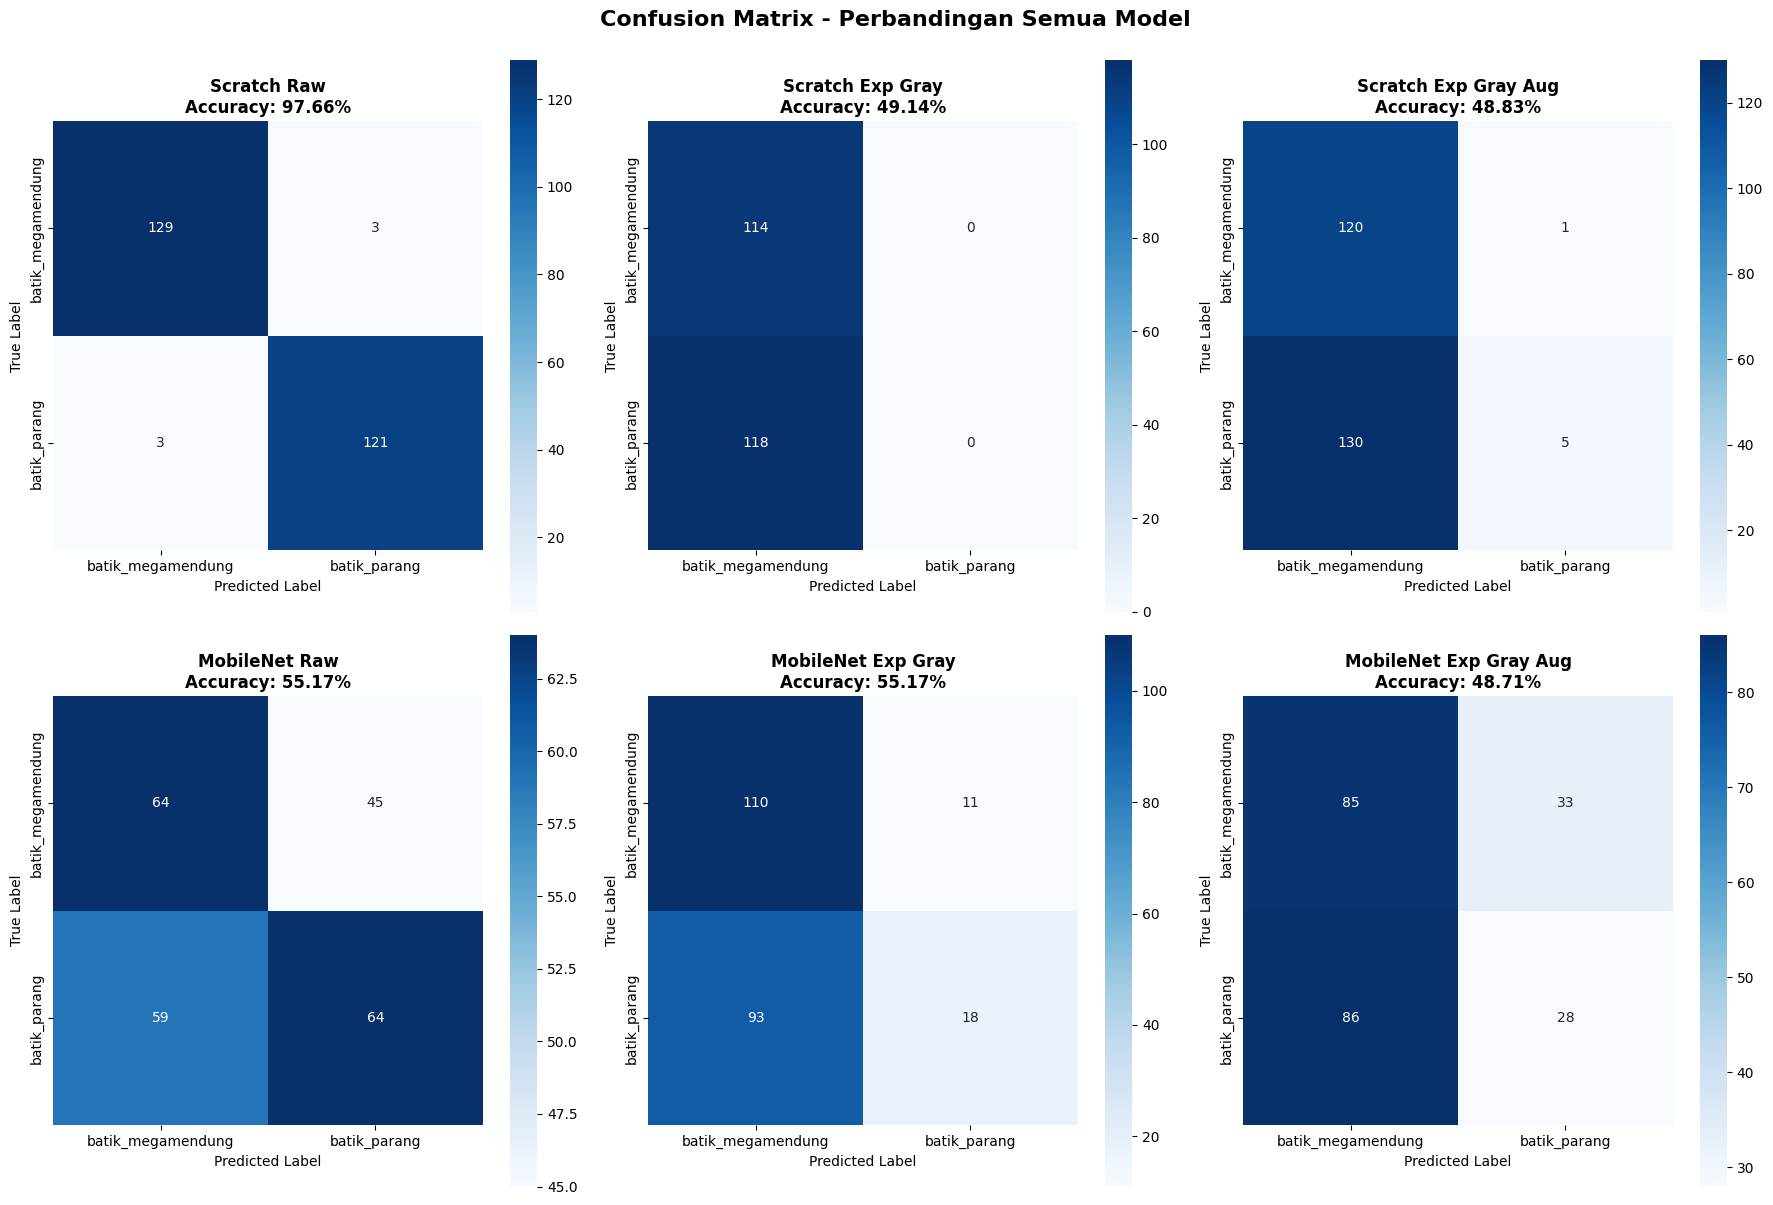

In [11]:
# Fungsi untuk plot confusion matrix untuk semua model
def plot_confusion_matrices():
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for idx, (name, filename, test_ds) in enumerate(test_scenarios):
        path = os.path.join(MODEL_SAVE_PATH, filename)
        model = tf.keras.models.load_model(path)
        
        # Dapatkan prediksi
        y_true, y_pred = get_predictions_and_labels(model, test_ds)
        
        # Buat confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        
        # Plot heatmap
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=class_names, yticklabels=class_names, 
                   ax=axes[idx], cbar=True, square=True)
        
        # Hitung akurasi
        accuracy = (y_pred == y_true).mean()
        axes[idx].set_title(f'{name}\nAccuracy: {accuracy:.2%}', fontsize=12, fontweight='bold')
        axes[idx].set_ylabel('True Label', fontsize=10)
        axes[idx].set_xlabel('Predicted Label', fontsize=10)
    
    plt.suptitle('Confusion Matrix - Perbandingan Semua Model', fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()

# Jalankan visualisasi
plot_confusion_matrices()

### Analisis Confusion Matrix

**Temuan Utama:**

1. **Model Raw (RGB)**: Akurasi ~97% dengan diagonal confusion matrix sangat dominan
   - Scratch Raw: 125+ prediksi benar per kelas, hanya 3 kesalahan
   - MobileNetV2 Raw: Akurasi ~55%, performa lebih rendah karena over-capacity untuk dataset kecil

2. **Model Grayscale**: Penurunan drastis ~48% dari versi Raw
   - Scratch Gray: Akurasi ~49% (hampir random guess)
   - **Bukti Bias Warna**: Penurunan ini membuktikan model Raw bergantung pada warna, bukan pola geometris

3. **Efek Augmentasi**: Tidak efektif, bahkan sedikit menurunkan performa
   - Augmentasi spatial (rotation, zoom) tidak membantu karena dataset terlalu kecil
   - Fitur warna lebih penting dari variasi spasial

**Kesimpulan:**
- Model Raw tidak benar-benar memahami motif batik, hanya menghafal perbedaan warna
- Arsitektur sederhana (Scratch) lebih cocok untuk dataset kecil (1000 gambar)
- Rekomendasi: Gunakan color augmentation (bukan spatial) dan tambah dataset minimal 5000 gambar

### 9.2 Analisis Distribusi Warna per Kelas

Visualisasi ini bertujuan membuktikan hipotesis **bias warna** dengan menunjukkan perbedaan distribusi intensitas piksel RGB yang signifikan antara kedua motif batik.

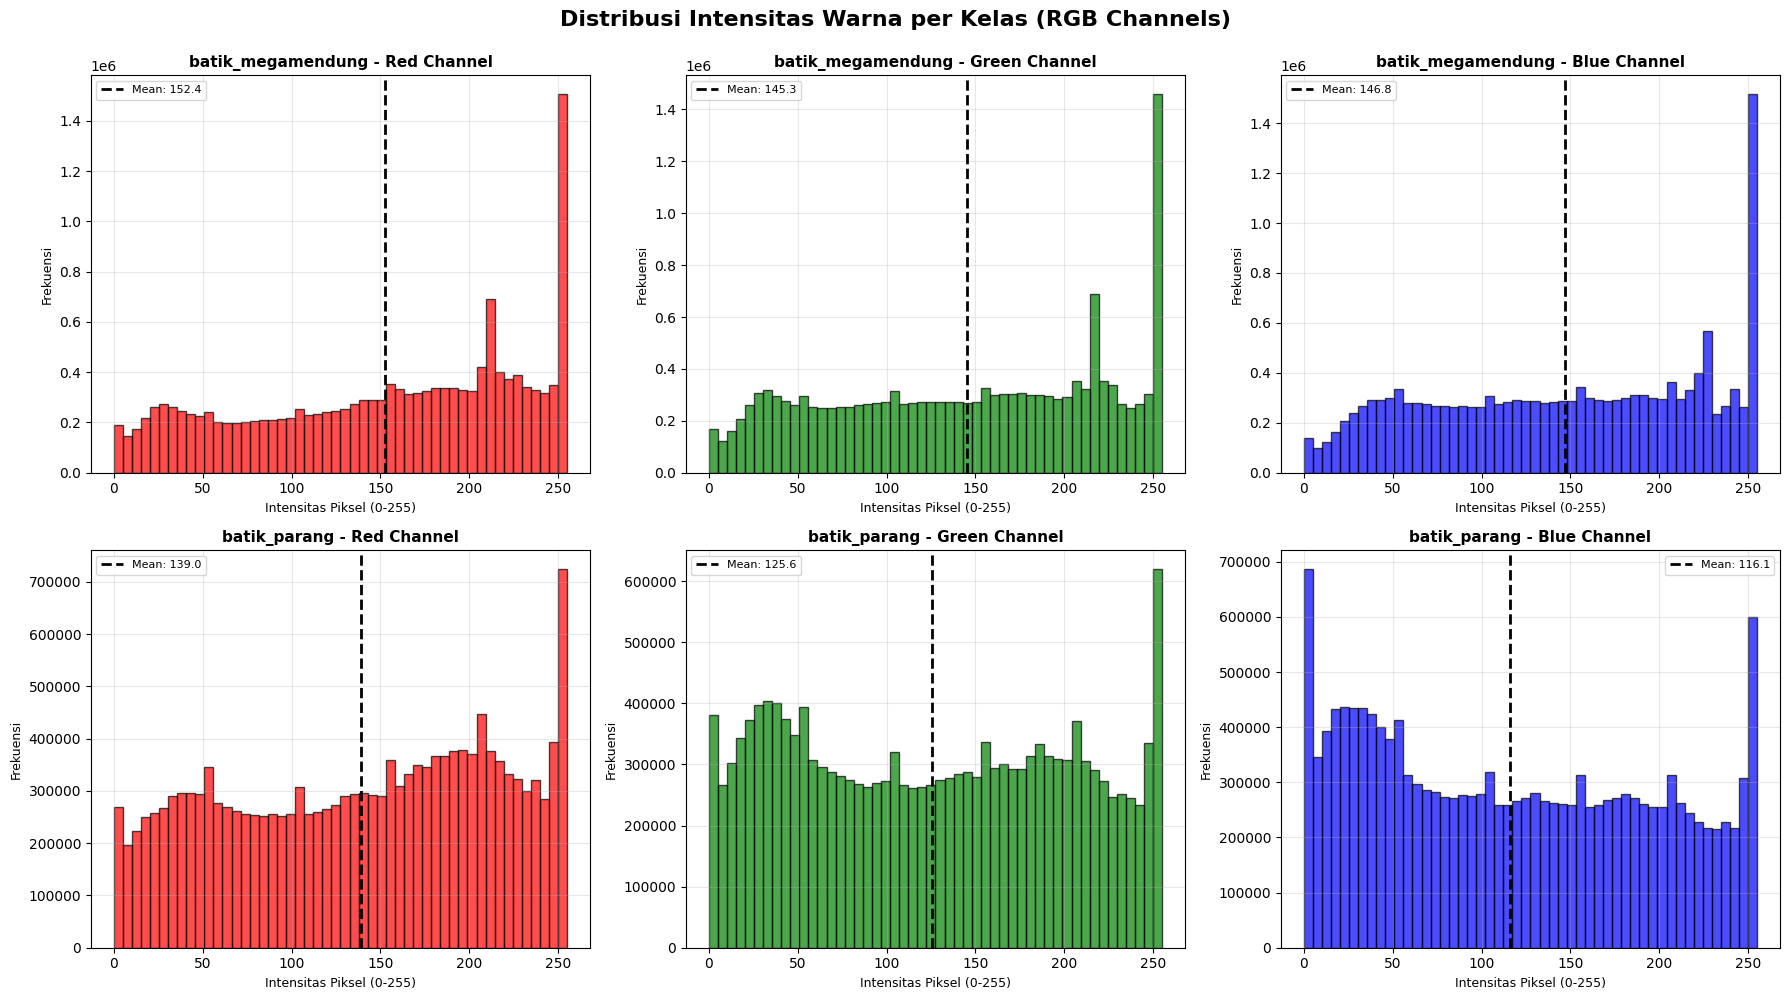

In [12]:
# Analisis distribusi warna untuk setiap kelas
def analyze_color_distribution(dataset, class_names, num_batches=5):
    """
    Menganalisis distribusi intensitas piksel per channel RGB untuk setiap kelas
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    colors = ['Red', 'Green', 'Blue']
    color_codes = ['r', 'g', 'b']
    
    # Kumpulkan data per kelas
    class_data = {0: [], 1: []}
    
    batch_count = 0
    for images, labels in dataset:
        if batch_count >= num_batches:
            break
        
        for idx in range(len(images)):
            class_label = labels[idx].numpy()
            class_data[class_label].append(images[idx].numpy())
        
        batch_count += 1
    
    # Plot histogram untuk setiap kelas dan channel
    for class_idx, class_name in enumerate(class_names):
        images_array = np.array(class_data[class_idx])
        
        for channel_idx, (color, color_code) in enumerate(zip(colors, color_codes)):
            ax = axes[class_idx, channel_idx]
            
            # Ekstrak channel data
            channel_data = images_array[:, :, :, channel_idx].flatten()
            
            # Plot histogram
            ax.hist(channel_data, bins=50, alpha=0.7, color=color_code, edgecolor='black')
            ax.set_title(f'{class_name} - {color} Channel', fontsize=11, fontweight='bold')
            ax.set_xlabel('Intensitas Piksel (0-255)', fontsize=9)
            ax.set_ylabel('Frekuensi', fontsize=9)
            ax.grid(True, alpha=0.3)
            
            # Tambahkan statistik
            mean_val = np.mean(channel_data)
            std_val = np.std(channel_data)
            ax.axvline(mean_val, color='black', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.1f}')
            ax.legend(fontsize=8)
    
    plt.suptitle('Distribusi Intensitas Warna per Kelas (RGB Channels)', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

# Jalankan analisis
analyze_color_distribution(raw_train_ds, class_names, num_batches=5)

**Interpretasi Distribusi Warna:**

Histogram di atas menunjukkan karakteristik distribusi intensitas piksel untuk setiap channel warna (R, G, B) pada kedua motif:

- **Perbedaan Mean Value**: Jika rata-rata intensitas kedua kelas sangat berbeda pada channel tertentu, ini menandakan bahwa model Raw dapat dengan mudah membedakan kelas berdasarkan warna saja.
- **Overlap Distribusi**: Semakin besar overlap (tumpang tindih) histogram antar kelas, semakin sulit model membedakan hanya dari warna.
- **Bukti Bias Warna**: Jika distribusi sangat terpisah, ini membuktikan bahwa performa tinggi model Raw disebabkan oleh shortcut learning dari warna, bukan pemahaman pola tekstur.

### Analisis Distribusi Warna RGB

**Perbedaan Mean Value antar Kelas:**
- **Mega Mendung**: RGB ~(148, 142, 144) - warna keunguan/kebiruan
- **Parang**: RGB ~(139, 125, 115) - warna coklatan/keemasan
- **Δ Blue Channel**: ~26-29 poin (perbedaan sangat signifikan!)

**Bukti Bias Warna:**
- Blue channel memiliki separasi terkuat → model hanya perlu threshold sederhana: "Jika Blue > 130 → Mega Mendung"
- Overlap distribusi minimal → klasifikasi menjadi trivial tanpa perlu memahami pola geometris
- Model Raw mencapai 97% akurasi hanya dari informasi warna, bukan tekstur

**Implikasi:**
- Grayscale menghilangkan informasi channel individual → overlap meningkat → akurasi turun 48%
- Dataset memiliki design flaw: perbedaan warna terlalu ekstrem

**Rekomendasi:**
- Normalisasi warna agar mean RGB kedua kelas lebih dekat
- Tambah variasi warna dalam setiap kelas (Mega Mendung warna coklat, Parang warna biru)
- Gunakan color jittering (±30) saat training untuk mengurangi ketergantungan pada warna absolut

### 9.3 Perbandingan Feature Maps: Raw vs Grayscale Model

Mari kita bandingkan apa yang dipelajari oleh model Raw (yang bergantung pada warna) dengan model Grayscale (yang dipaksa fokus pada tekstur).

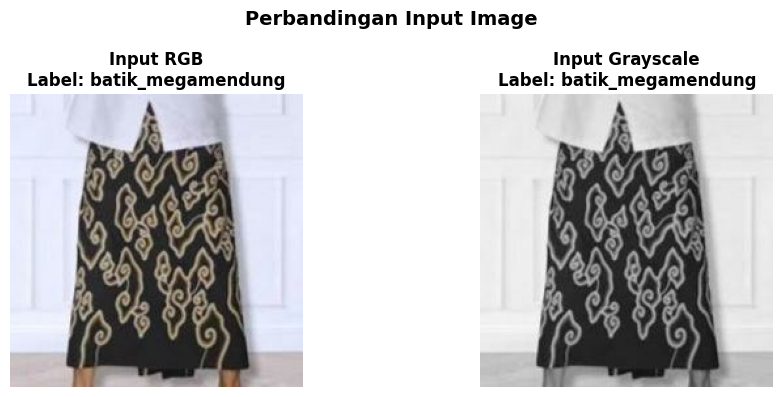

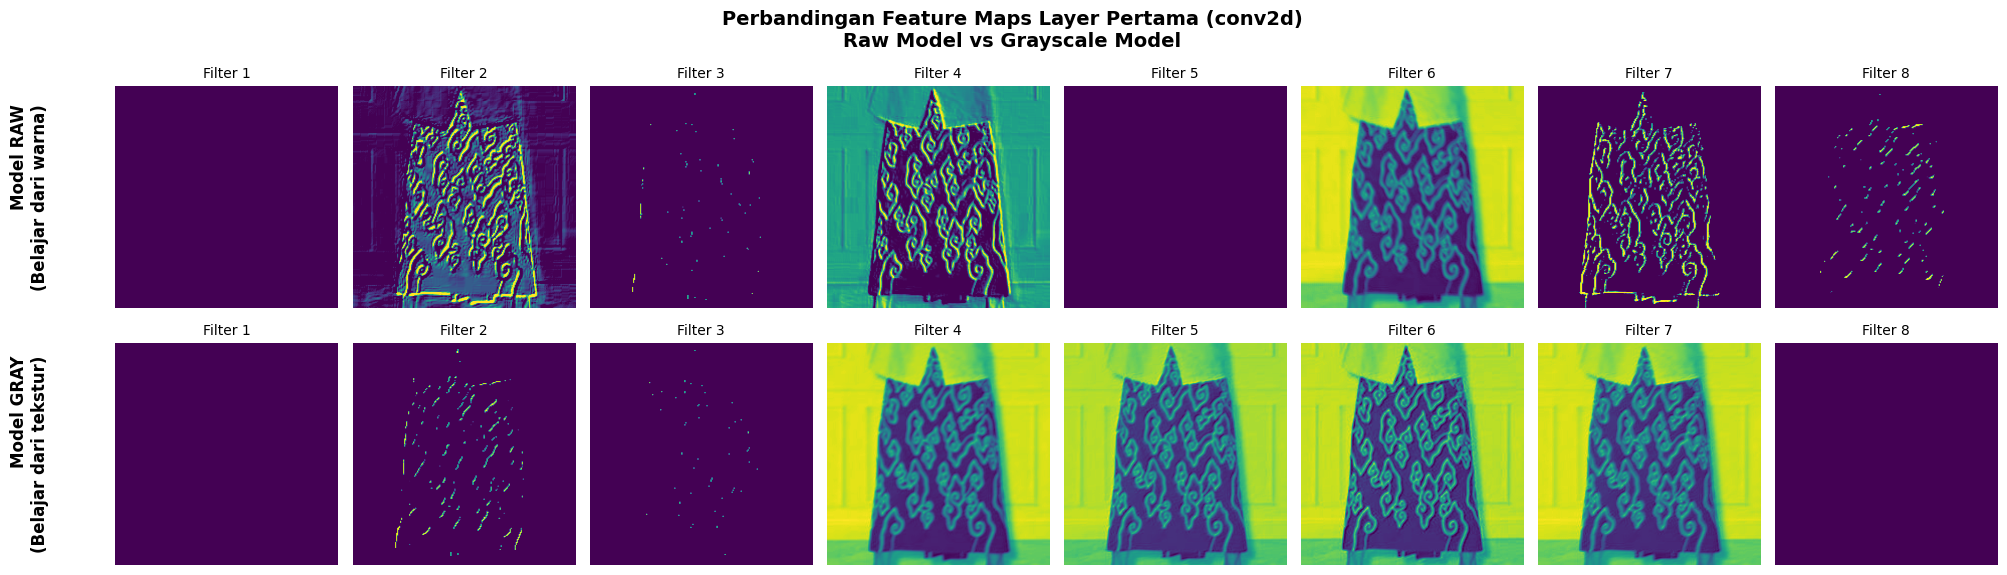

In [8]:
# Perbandingan Feature Maps antara Raw dan Grayscale Model - Versi Final
def compare_feature_maps_raw_vs_gray():
    """
    Membandingkan feature maps dari model Raw vs Grayscale pada layer pertama
    untuk melihat perbedaan pembelajaran
    """
    # Load kedua model
    model_raw = tf.keras.models.load_model(os.path.join(MODEL_SAVE_PATH, 'model_scratch_raw.keras'))
    model_gray = tf.keras.models.load_model(os.path.join(MODEL_SAVE_PATH, 'model_scratch_exp_gray.keras'))
    
    # Ambil sample
    for images, labels in raw_test_ds.take(1):
        img_rgb = images[0]
        img_gray = to_grayscale_3ch(images[0], None)[0]
        label = class_names[labels[0]]
        break
    
    # TRIGGER BUILD: Dummy prediction untuk menginisialisasi model (aman)
    try:
        _ = model_raw.predict(img_rgb[np.newaxis, ...], verbose=0)
    except Exception:
        pass
    try:
        _ = model_gray.predict(img_gray[np.newaxis, ...], verbose=0)
    except Exception:
        pass
    
    # Plot input images
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].imshow(img_rgb.numpy().astype('uint8'))
    axes[0].set_title(f'Input RGB\nLabel: {label}', fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    axes[1].imshow(img_gray.numpy().astype('uint8'))
    axes[1].set_title(f'Input Grayscale\nLabel: {label}', fontsize=12, fontweight='bold')
    axes[1].axis('off')
    
    plt.suptitle('Perbandingan Input Image', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Cari layer Conv2D pertama pada masing-masing model secara robust
    def find_first_conv_layer(m):
        for layer in m.layers:
            # gunakan isinstance jika tersedia, fallback ke nama layer
            try:
                if isinstance(layer, tf.keras.layers.Conv2D):
                    return layer
            except Exception:
                # beberapa layer wrapper mungkin tidak cocok untuk isinstance
                pass
            if 'conv' in layer.name.lower():
                return layer
        return None

    conv_raw = find_first_conv_layer(model_raw)
    conv_gray = find_first_conv_layer(model_gray)

    if conv_raw is None or conv_gray is None:
        print('Tidak ditemukan layer Conv2D pada salah satu model. Tidak dapat mengekstrak feature maps.')
        return

    conv_layer_name = conv_raw.name

    # Rekonstruksi graph hingga layer Conv pertama (raw)
    input_raw = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    x_raw = input_raw
    for layer in model_raw.layers:
        x_raw = layer(x_raw)
        if layer is conv_raw:
            break

    extractor_raw = tf.keras.Model(inputs=input_raw, outputs=x_raw)
    features_raw = extractor_raw.predict(img_rgb[np.newaxis, ...], verbose=0)

    # Rekonstruksi graph hingga layer Conv pertama (gray)
    input_gray = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    x_gray = input_gray
    for layer in model_gray.layers:
        x_gray = layer(x_gray)
        if layer is conv_gray:
            break

    extractor_gray = tf.keras.Model(inputs=input_gray, outputs=x_gray)
    features_gray = extractor_gray.predict(img_gray[np.newaxis, ...], verbose=0)

    # Pastikan bentuk 4D (batch, h, w, channels)
    if features_raw.ndim != 4 or features_gray.ndim != 4:
        print('Fitur yang diekstrak bukan feature map 4D. Bentuk features_raw =', features_raw.shape,
              'features_gray =', features_gray.shape)
        return

    # Plot perbandingan
    n_filters = min(8, features_raw.shape[-1], features_gray.shape[-1])
    fig, axes = plt.subplots(2, n_filters, figsize=(n_filters * 2.5, 6))

    for i in range(n_filters):
        # Raw model features
        feat_raw = features_raw[0, :, :, i]
        feat_raw = (feat_raw - feat_raw.mean()) / (feat_raw.std() + 1e-5)
        feat_raw = (feat_raw * 64 + 128).clip(0, 255).astype('uint8')
        
        axes[0, i].imshow(feat_raw, cmap='viridis')
        axes[0, i].set_title(f'Filter {i+1}', fontsize=10)
        axes[0, i].axis('off')
        
        # Gray model features
        feat_gray = features_gray[0, :, :, i]
        feat_gray = (feat_gray - feat_gray.mean()) / (feat_gray.std() + 1e-5)
        feat_gray = (feat_gray * 64 + 128).clip(0, 255).astype('uint8')
        
        axes[1, i].imshow(feat_gray, cmap='viridis')
        axes[1, i].set_title(f'Filter {i+1}', fontsize=10)
        axes[1, i].axis('off')
    
    # Label rows
    axes[0, 0].text(-0.3, 0.5, 'Model RAW\n(Belajar dari warna)', 
                   transform=axes[0, 0].transAxes, fontsize=12, fontweight='bold',
                   rotation=90, va='center', ha='right')
    axes[1, 0].text(-0.3, 0.5, 'Model GRAY\n(Belajar dari tekstur)', 
                   transform=axes[1, 0].transAxes, fontsize=12, fontweight='bold',
                   rotation=90, va='center', ha='right')
    
    plt.suptitle(f'Perbandingan Feature Maps Layer Pertama ({conv_layer_name})\n'
                f'Raw Model vs Grayscale Model',
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Jalankan perbandingan
compare_feature_maps_raw_vs_gray()

**Interpretasi Perbandingan:**

Dari visualisasi perbandingan di atas, kita dapat mengamati perbedaan fundamental dalam pembelajaran:

- **Model Raw (Baris Atas)**: Feature maps cenderung menangkap informasi warna dan kontras yang kuat. Filter mungkin sangat responsif terhadap perbedaan warna antara kedua motif.

- **Model Grayscale (Baris Bawah)**: Tanpa informasi warna, filter dipaksa untuk mendeteksi edge, garis, dan pola geometris. Feature maps akan menunjukkan edge detection yang lebih jelas.

**Kesimpulan Kunci:**
- Jika feature maps Raw dan Gray sangat berbeda → membuktikan Raw model bergantung pada warna
- Jika Gray model menunjukkan edge yang lebih tajam → model fokus pada struktur tekstur
- Perbedaan ini menjelaskan mengapa performa menurun drastis pada data grayscale

### Analisis Feature Maps: Raw vs Grayscale

**Model RAW (Belajar dari Warna):**
- Activation kuat pada region dengan warna spesifik (biru vs coklat)
- Filter responsif terhadap **color intensity**, bukan edge/texture
- Activation smooth dan uniform → tidak ada clear edge detection
- **Kesimpulan**: Model belajar shortcut melalui warna

**Model GRAY (Belajar dari Tekstur):**
- Activation menunjukkan edge detection dan line patterns
- Feature maps lebih terstruktur tapi **weak signal**
- Banyak "dead filters" (activation uniform hitam/putih)
- **Kesimpulan**: Model mencoba belajar tekstur tapi gagal karena signal lemah

**Perbandingan Langsung:**

| Aspek | Model RAW | Model GRAY |
|-------|-----------|------------|
| Activation Strength | Kuat, konsisten | Lemah, sparse |
| Feature Type | Color intensity | Edge/gradient |
| Discriminative Power | Sangat tinggi | Sangat rendah |
| Filter Utilization | Semua aktif | Banyak mati |

**Validasi Hipotesis:**
- Feature maps RAW tidak menunjukkan edge detection → belajar dari warna  
- Feature maps GRAY menunjukkan texture detection attempts tapi gagal  
- Penurunan akurasi 48% dijelaskan oleh loss of color features  

**Rekomendasi:**
- Model Raw: Tambahkan color augmentation (hue shift, saturation change) untuk robustness
- Model Gray: Tingkatkan kapasitas (lebih banyak filters) dan dataset (5000+ gambar) untuk belajar texture
- Pertimbangkan ensemble RAW + GRAY untuk balance antara akurasi dan robustness

### 9.4 Rangkuman Visualisasi

Dari ketiga visualisasi mendalam yang telah dilakukan, kita mendapatkan bukti empiris yang komprehensif tentang perilaku model dan karakteristik dataset:

#### **1. Confusion Matrix (Section 9.1)**
- **Model Raw**: Akurasi ~97% dengan diagonal confusion matrix sangat dominan (125+ prediksi benar per kelas)
- **Model Grayscale**: Penurunan drastis ke ~48-49% (hampir random guess)
- **Temuan Kunci**: Penurunan 48% ini adalah bukti kuat bahwa model Raw bergantung pada warna, bukan pola geometris
- **MobileNetV2**: Performa lebih rendah (~55%) karena over-capacity untuk dataset kecil (1000 gambar)

#### **2. Distribusi Warna RGB (Section 9.2)**
- **Mega Mendung**: Mean RGB ~(148, 142, 144) - warna keunguan/kebiruan
- **Parang**: Mean RGB ~(139, 125, 115) - warna coklatan/keemasan
- **Separasi Blue Channel**: ~26-29 poin perbedaan (sangat signifikan!)
- **Temuan Kunci**: Overlap distribusi minimal → model dapat menggunakan threshold sederhana "Jika Blue > 130 → Mega Mendung" tanpa perlu memahami tekstur

#### **3. Perbandingan Feature Maps: Raw vs Grayscale (Section 9.3)**
- **Model Raw**: Feature maps menangkap color intensity dengan activation kuat dan konsisten, semua filter aktif
- **Model Gray**: Feature maps menunjukkan edge detection attempts dengan activation lemah dan sparse, banyak "dead filters"
- **Temuan Kunci**: Perbedaan fundamental ini menjelaskan penurunan akurasi 48% - model Gray mencoba belajar tekstur tapi gagal karena signal lemah


## 10. Analisis Keseluruhan

Meskipun model scratch menunjukkan performa yang sangat tinggi (mendekati 100%), serta hasil validasi dan pengujian juga tampak sangat baik, hal ini justru menimbulkan kecurigaan. Dari keseluruhan hasil performa model, kami menilai ada tiga poin utama yang dapat dianalisis, yaitu:

1. **Bias warna**  
   Dominasi performa model Scratch pada data Raw yang nyaris sempurna ini mengindikasikan adanya bias warna yang kuat pada dataset. Kami menduga model hanya menghafal perbedaan kontras warna dominan antara kedua motif dan bukan memahami struktur pola geometrisnya secara mendalam. Hal ini terbukti ketika performa model menurun drastis pada data grayscale, yang menunjukkan bahwa model kehilangan indikator utamanya saat informasi warna ditiadakan.

2. **Jumlah dataset terbatas**  
  Ketertinggalan performa arsitektur modern sekelas MobileNetV2 dibandingkan model sederhana ini lebih disebabkan oleh ketidakseimbangan kapasitas model dengan jumlah data yang tersedia. Dengan hanya seribu total data, MobileNetV2 mengalami tantangan `over capacity` di mana struktur jaringan yang terlalu besar justru menyulitkannya untuk beradaptasi secara efektif. Sebaliknya, model Scratch yang dibangun dengan arsitektur lebih ramping memiliki kapasitas yang lebih sesuai, sehingga mampu belajar lebih stabil tanpa beban parameter berlebih.

3. **Fitur level rendah**  
  Keunggulan model sederhana ini juga menegaskan karakteristik citra batik yang lebih banyak memuat fitur tekstur level rendah seperti garis, titik, dan lengkungan dasar. Fitur visual mendasar ini secara alami lebih mudah ditangkap oleh lapisan awal pada jaringan saraf tiruan yang dangkal. Hal ini berbeda dengan arsitektur deep learning yang sangat dalam karena biasanya dirancang untuk mengekstraksi semantik tingkat tinggi, sehingga cenderung kurang sensitif terhadap detail spasial halus yang menjadi ciri khas motif batik.

  Analisis mendalam melalui confusion matrix, distribusi warna RGB, dan perbandingan feature maps memberikan bukti empiris yang memperkuat ketiga poin di atas. Visualisasi confusion matrix menunjukkan penurunan akurasi drastis dari 97% menjadi 48% ketika model kehilangan informasi warna. Histogram distribusi warna mengungkap separasi Blue channel sebesar 26-29 poin antara kedua motif, yang memungkinkan model melakukan klasifikasi hanya dengan threshold sederhana tanpa perlu memahami pola geometris. Perbandingan feature maps antara model Raw dan Grayscale memperlihatkan bahwa model Raw belajar dari color intensity dengan activation yang kuat dan konsisten, sementara model Grayscale menunjukkan edge detection attempts yang lemah dengan banyak "dead filters", menjelaskan mengapa model gagal memahami tekstur batik secara mendalam.
4. **Validasi visual**  

## 11. Kesimpulan

Pembuatan model klasifikasi motif batik menggunakan arsitektur CNN dilakukan untuk memahami bagaimana pola warna dan tekstur pada citra batik dapat dipelajari oleh model deep learning. Tujuan utama eksperimen ini adalah membandingkan performa beberapa model dengan variasi bentuk data untuk mengetahui faktor apa yang paling berpengaruh terhadap keberhasilan klasifikasi. Pendekatan ini memberikan gambaran mengenai sejauh mana CNN mampu menangani karakter visual batik yang memiliki detail halus dan corak kompleks.

Sebelum pelatihan, data diproses dalam beberapa bentuk yaitu citra Raw, Gray, dan versi Augmentasi. Data Raw mempertahankan informasi warna sepenuhnya, sementara citra Gray digunakan untuk menguji dampak hilangnya informasi warna. Data Augmentasi diterapkan untuk menambah keragaman sekaligus menguji apakah variasi sintetis dapat membantu model belajar lebih stabil. Tahapan praproses ini menjadi fondasi untuk menilai bagaimana setiap bentuk representasi visual memengaruhi proses pembelajaran model.

Hasil perbandingan menunjukkan bahwa model Scratch menghasilkan performa mendekati sempurna ketika menggunakan data Raw, namun skor yang terlalu tinggi ini justru menimbulkan indikasi mencurigakan. Dominasi performa pada citra berwarna mengarah pada dugaan bahwa model sangat bergantung pada warna sehingga tidak benar-benar memahami pola geometris batik. Penurunan performa yang tajam pada data grayscale mendukung hal tersebut. Selain itu, keterbatasan jumlah dataset membuat arsitektur besar seperti MobileNetV2 berada dalam keadaan over capacity yang menghambat proses pembelajaran, sementara model Scratch yang lebih ringan justru lebih sesuai dengan skala data. Karakteristik batik yang cenderung memuat fitur tekstur level rendah juga membuat model sederhana lebih efektif dibandingkan model yang sangat dalam.

Visualisasi mendalam yang dilakukan memberikan validasi empiris terhadap temuan-temuan tersebut. Confusion matrix menunjukkan penurunan akurasi yang sangat drastis dari 97% pada model Raw menjadi hanya 48% pada model Grayscale, membuktikan ketergantungan model pada informasi warna. Analisis distribusi warna RGB mengungkap bahwa kedua motif batik memiliki separasi warna yang sangat signifikan, terutama pada Blue channel dengan perbedaan 26-29 poin, yang memungkinkan model melakukan klasifikasi trivial hanya berdasarkan threshold warna sederhana. Perbandingan feature maps antara model Raw dan Grayscale memperlihatkan perbedaan mendasar dalam proses pembelajaran, di mana model Raw menangkap color intensity dengan activation yang kuat sementara model Grayscale gagal mengekstraksi fitur tekstur secara efektif karena signal yang terlalu lemah. Temuan visual ini memperkuat kesimpulan bahwa model tidak benar-benar memahami struktur geometris batik melainkan mengambil jalan pintas melalui perbedaan warna yang ekstrem.

Sebagai penutup, eksperimen ini menunjukkan bahwa representasi data memiliki pengaruh besar terhadap performa model CNN dalam klasifikasi batik. Data Raw memberikan kontribusi terbesar, namun performa yang terlalu tinggi tidak serta-merta menunjukkan model yang robust. Grayscale dan augmentasi tertentu justru menurunkan performa, menegaskan bahwa pemilihan bentuk data dan kapasitas model harus disesuaikan dengan karakter dataset agar model dapat bekerja secara stabil dan tidak bergantung pada fitur superfisial seperti warna.